In [40]:
library(smoof)
library(ggplot2)
library(dplyr)
library(GA)

Warning message:
"pakiet 'ecr' został zbudowany w wersji R 4.4.2"
Ładowanie wymaganego pakietu: BBmisc

Warning message:
"pakiet 'BBmisc' został zbudowany w wersji R 4.4.2"

Dołączanie pakietu: 'BBmisc'


Następujące obiekty zostały zakryte z 'package:dplyr':

    coalesce, collapse, symdiff


Następujący obiekt został zakryty z 'package:base':

    isFALSE



Dołączanie pakietu: 'ecr'


Następujące obiekty zostały zakryte z 'package:BBmisc':

    explode, normalize


Następujący obiekt został zakryty z 'package:dplyr':

    mutate


Następujący obiekt został zakryty z 'package:utils':

    toLatex




Deklaracja funkcji testowych

In [3]:
rosenbrock_2d <- makeRosenbrockFunction(dimensions = 2)
rosenbrock_10d <- makeRosenbrockFunction(dimensions = 10)
rosenbrock_20d <- makeRosenbrockFunction(dimensions = 20)

rastrigin_2d <- makeRastriginFunction(dimensions = 2)
rastrigin_10d <- makeRastriginFunction(dimensions = 10)
rastrigin_20d <- makeRastriginFunction(dimensions = 20)

NO_STARTS <- 50

get_domain <- function(fun) {
  list(
    lower = getLowerBoxConstraints(fun),
    upper = getUpperBoxConstraints(fun)
  )
}

domains <- list(
  rosenbrock_2d = get_domain(rosenbrock_2d),
  rosenbrock_10d = get_domain(rosenbrock_10d),
  rosenbrock_20d = get_domain(rosenbrock_20d),
  rastrigin_2d = get_domain(rastrigin_2d),
  rastrigin_10d = get_domain(rastrigin_10d),
  rastrigin_20d = get_domain(rastrigin_20d)
)

print(domains)

$rosenbrock_2d
$rosenbrock_2d$lower
x1 x2 
-5 -5 

$rosenbrock_2d$upper
x1 x2 
10 10 


$rosenbrock_10d
$rosenbrock_10d$lower
 x1  x2  x3  x4  x5  x6  x7  x8  x9 x10 
 -5  -5  -5  -5  -5  -5  -5  -5  -5  -5 

$rosenbrock_10d$upper
 x1  x2  x3  x4  x5  x6  x7  x8  x9 x10 
 10  10  10  10  10  10  10  10  10  10 


$rosenbrock_20d
$rosenbrock_20d$lower
 x1  x2  x3  x4  x5  x6  x7  x8  x9 x10 x11 x12 x13 x14 x15 x16 x17 x18 x19 x20 
 -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5  -5 

$rosenbrock_20d$upper
 x1  x2  x3  x4  x5  x6  x7  x8  x9 x10 x11 x12 x13 x14 x15 x16 x17 x18 x19 x20 
 10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10 


$rastrigin_2d
$rastrigin_2d$lower
   x1    x2 
-5.12 -5.12 

$rastrigin_2d$upper
  x1   x2 
5.12 5.12 


$rastrigin_10d
$rastrigin_10d$lower
   x1    x2    x3    x4    x5    x6    x7    x8    x9   x10 
-5.12 -5.12 -5.12 -5.12 -5.12 -5.12 -5.12 -5.12 -5.12 -5.12 

$rastrigin_10d$upper
  x1   x2   x

Funkcja ms_run znajduje minimum funcji za pomocą algorytmu MS

In [4]:
ms_run <- function(fun, domain, starts) {
  total_evals <- 0
  best_value <- Inf
  
  for (i in 1:starts) {
    x0 <- runif(length(domain$lower), domain$lower, domain$upper)
    
    result <- optim(x0, fun, method = "L-BFGS-B", lower = domain$lower, upper = domain$upper)
    
    total_evals <- total_evals + result$counts[["function"]]
    if (result$value < best_value) best_value <- result$value
  }
  
  list(best = best_value, evals = total_evals)
}

Funkcja ga_run znajduje minimum funcji za pomocą algorytmu GA ( biblioteka GA )

In [58]:
ga_run <- function(fun, domain, budget) {
  ga_result <- ga(
    type = "real-valued",
    fitness = function(x) -fun(x),
    lower = domain$lower,
    upper = domain$upper,
    popSize = 50,
    maxiter = budget,
    run = 20,             # Stop if the best solution doesn't improve for 10 generations
    monitor = FALSE
  )
  
  return(-ga_result@fitnessValue)  # GA maximizes, so return the negative value
}

Funkcja ga_run_ecr znajduje minimum funcji za pomocą algorytmu GA ( biblioteka ecr )

In [72]:
# Pierdole, nie działa
# Do usunięcia
library(ecr)

ga_run_ecr <- function(fun, domain, budget) {
  # 1. Funkcja celu: odwrócenie znaku (maksymalizacja przez minimalizację)
  fitness_function <- function(x) -fun(x)
  
  # 2. Inicjalizacja populacji (rozmiar 50, liczba wymiarów = długość dolnych granic)
  n_dim <- length(domain$lower)  # Liczba wymiarów
  population <- genReal(n = 50, n.dim = n_dim, lower = domain$lower, upper = domain$upper)
  
  # 3. Operatory genetyczne
  recombinator <- function(parents) {
    # Zastosowanie recSBX do każdej pary rodziców
    offspring <- lapply(seq(1, nrow(parents), by = 2), function(i) {
      recSBX(
        inds = list(parents[i, ], parents[i + 1, ]),
        lower = domain$lower,
        upper = domain$upper,
        eta = 15
      )
    })
    do.call(rbind, offspring)
  }
  
  mutator <- function(ind) {
    # Zastosowanie mutacji wielomianowej dla każdego osobnika
    mutPolynomial(
      ind = ind,
      lower = domain$lower,
      upper = domain$upper,
      eta = 20
    )
  }
  
  # 4. Główna pętla: iteracje algorytmu genetycznego
  for (iter in seq_len(budget)) {
    # 4.1. Obliczenie fitnessu dla populacji
    fitness_values <- evaluateFitness(population, fitness_function)
    
    # 4.2. Selekcja rodziców na podstawie fitnessu
    parents <- selectForMating(population, fitness = fitness_values, selector = selTournament(k = 2))
    
    # 4.3. Rekombinacja rodziców (tworzenie dzieci)
    offspring <- recombinator(parents)
    
    # 4.4. Mutacja dzieci
    offspring <- t(apply(offspring, 1, mutator))  # Mutacja każdego dziecka
    
    # 4.5. Ewaluacja dzieci
    offspring_fitness <- evaluateFitness(offspring, fitness_function)
    
    # 4.6. Zastępowanie populacji (mu + lambda)
    population <- replaceMuPlusLambda(population, offspring, fitness = c(fitness_values, offspring_fitness))
  }
  
  # 5. Pobranie najlepszego rozwiązania
  best_individual <- getFront(population)[1, ]
  best_value <- fitness_function(best_individual)  # Przywracamy oryginalną skalę
  return(-best_value)
}


algorytm prs

In [61]:
prs_run <- function(fun, domain, budget) {
  best_value <- Inf
  
  for (i in 1:budget) {
    x0 <- runif(length(domain$lower), domain$lower, domain$upper)
    result <- fun(x0)
    best_value <- min(best_value, result)
  }
  
  return(best_value)
}

Wykonanie pomiarów

In [75]:
run_experiments <- function(fun, domain, algorithm, budget, starts = NO_STARTS) {
  if (algorithm == "MS") {
    replicate(50, ms_run(fun, domain, starts)$best)
  } else if (algorithm == "GA") {
    replicate(50, ga_run(fun, domain, budget))
  } else if (algorithm == "PRS") {
    replicate(50, prs_run(fun, domain, budget))
  }
}

experiments <- list(
  rosenbrock_2d = list(fun = rosenbrock_2d, domain = domains$rosenbrock_2d),
  rosenbrock_10d = list(fun = rosenbrock_10d, domain = domains$rosenbrock_10d),
  rosenbrock_20d = list(fun = rosenbrock_20d, domain = domains$rosenbrock_20d),
  rastrigin_2d = list(fun = rastrigin_2d, domain = domains$rastrigin_2d),
  rastrigin_10d = list(fun = rastrigin_10d, domain = domains$rastrigin_10d),
  rastrigin_20d = list(fun = rastrigin_20d, domain = domains$rastrigin_20d)
)

# ms_results <- lapply(experiments, function(exp) {
#   ms_run(exp$fun, exp$domain, starts = NO_STARTS)
# })

# budget <- mean(sapply(ms_results, function(res) res$evals))

# tutaj powinno być budget = 1000 chyba
ga_results <- lapply(seq_along(experiments), function(i) {
  run_experiments(experiments[[i]]$fun, experiments[[i]]$domain, "GA", budget = 1000)
})

prs_results <- lapply(seq_along(experiments), function(i) {
  run_experiments(experiments[[i]]$fun, experiments[[i]]$domain, "PRS", budget = 1000)
})

# ms_best_values <- lapply(ms_results, function(res) rep(res$best, 50))

results <- data.frame(
  Function = rep(names(experiments), each = 50),
  Algorithm = rep(c("PRS", "GA"), each = 50 * length(experiments)),
  Value = c(unlist(prs_results), unlist(ga_results))
)

print(results)

          Function Algorithm        Value
1    rosenbrock_2d       PRS 2.713516e-01
2    rosenbrock_2d       PRS 2.117369e-01
3    rosenbrock_2d       PRS 2.086175e+00
4    rosenbrock_2d       PRS 8.565876e-02
5    rosenbrock_2d       PRS 1.042937e+00
6    rosenbrock_2d       PRS 1.465784e+00
7    rosenbrock_2d       PRS 1.568648e-01
8    rosenbrock_2d       PRS 3.178535e-01
9    rosenbrock_2d       PRS 1.888879e+00
10   rosenbrock_2d       PRS 4.700362e-01
11   rosenbrock_2d       PRS 6.290057e-01
12   rosenbrock_2d       PRS 4.321194e-01
13   rosenbrock_2d       PRS 1.261804e+00
14   rosenbrock_2d       PRS 2.676788e-01
15   rosenbrock_2d       PRS 1.617589e-01
16   rosenbrock_2d       PRS 6.662581e-01
17   rosenbrock_2d       PRS 2.499611e-01
18   rosenbrock_2d       PRS 1.325250e+00
19   rosenbrock_2d       PRS 6.041648e-01
20   rosenbrock_2d       PRS 3.649832e-01
21   rosenbrock_2d       PRS 1.266754e+00
22   rosenbrock_2d       PRS 2.672196e-02
23   rosenbrock_2d       PRS 3.411

Zapis do CSV

In [94]:
# Najpierw PRS
for (i in seq_along(prs_results)) {
    data <- unlist(prs_results[i])

    file_name <- paste0("./data/", names(experiments[i]),"PRS", ".csv")
    
    write.csv(data, file = file_name, row.names = FALSE)
}

# potem GA
for (i in seq_along(ga_results)) {
    data <- unlist(ga_results[i])

    file_name <- paste0("./data/", names(experiments[i]),"GA", ".csv")
    
    write.csv(data, file = file_name, row.names = FALSE)
}
# full res

write.csv(results, file = "./data/results", row.names = FALSE)

Wykresy

In [8]:
# res <- results %>% group_by(Function) %>% arrange(desc(Value)) %>% slice(-1:-5)
res <- results

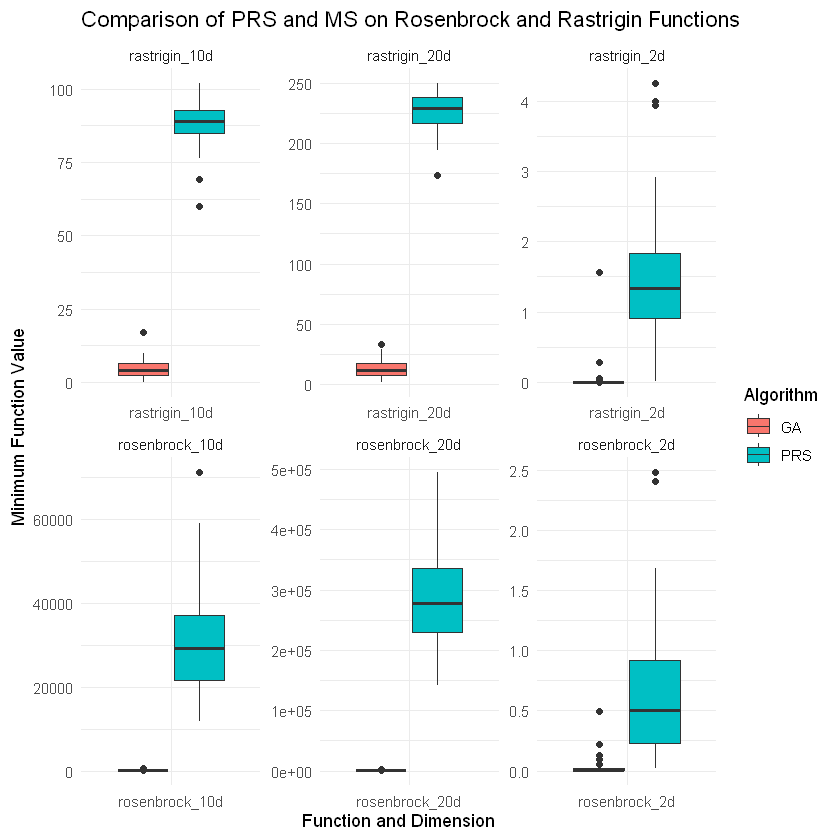

In [ ]:
ggplot(res, aes(x = Function, y = Value, fill = Algorithm)) +
  geom_boxplot() +
  facet_wrap(~Function, scales = "free") +
  labs(title = "Comparison of PRS and GA on Rosenbrock and Rastrigin Functions",
       y = "Minimum Function Value",
       x = "Function and Dimension") +
  theme_minimal()

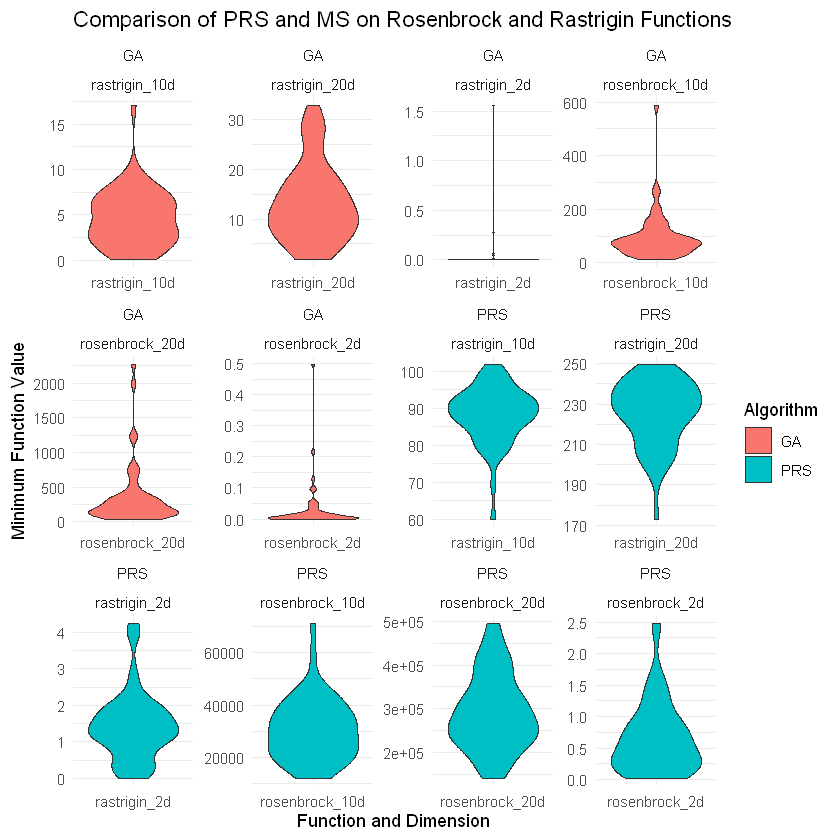

In [13]:
ggplot(res, aes(x = Function, y = Value, fill = Algorithm)) +
  geom_violin() +
  facet_wrap(~Algorithm + Function, scales = "free") +
  labs(title = "Comparison of PRS and GA on Rosenbrock and Rastrigin Functions",
       y = "Minimum Function Value",
       x = "Function and Dimension") +
  theme_minimal()

[1] "Generating plot for rosenbrock_2d PRS"
[1] "Generating plot for rosenbrock_2d GA"


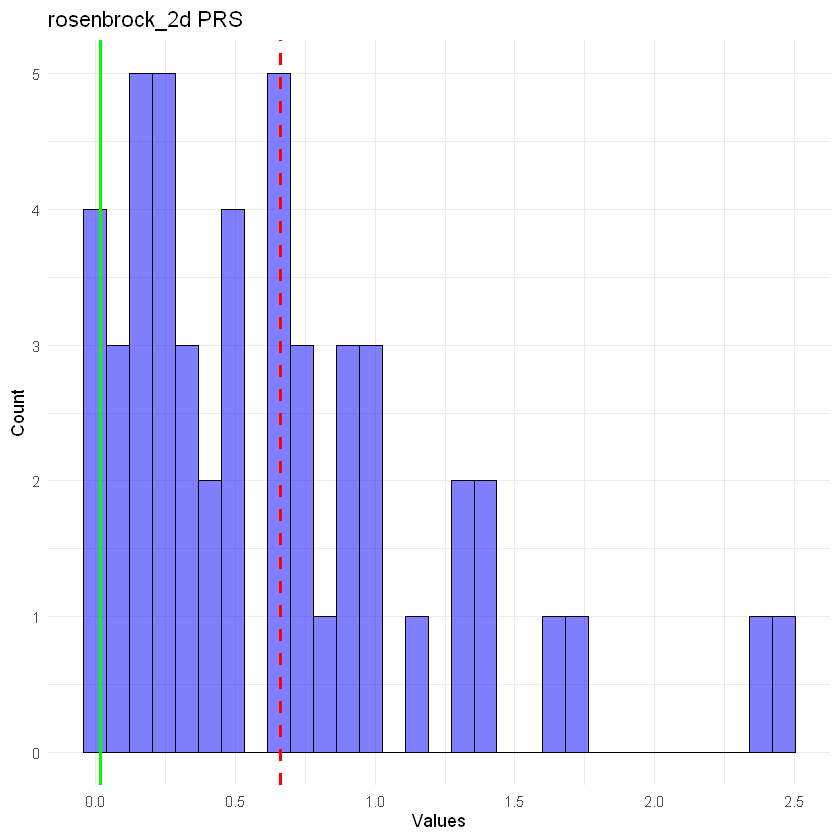

[1] "Generating plot for rosenbrock_10d PRS"


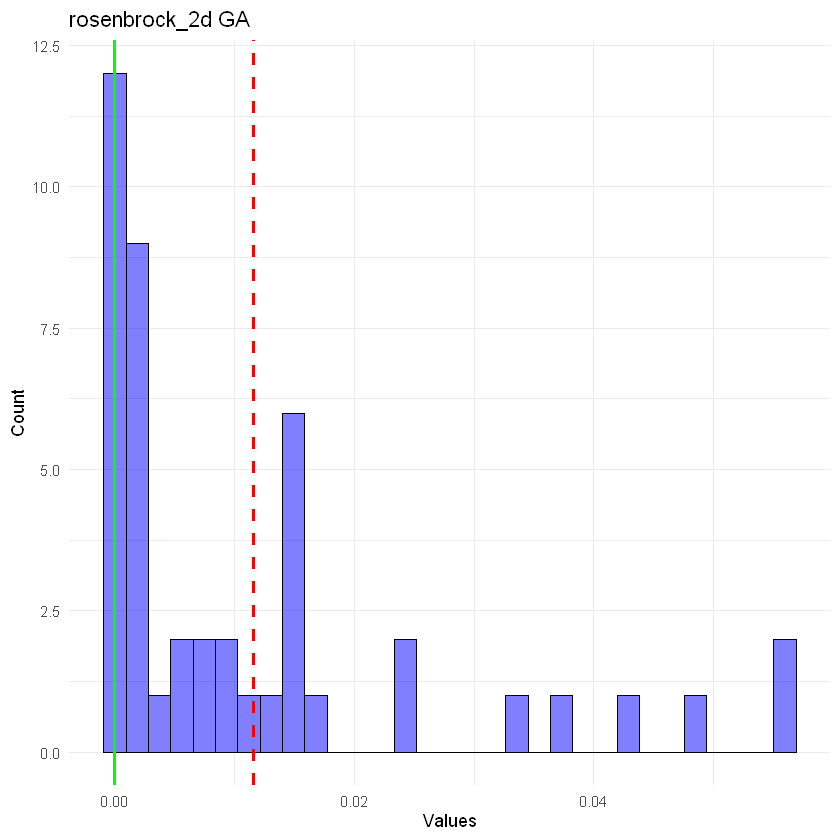

[1] "Generating plot for rosenbrock_10d GA"


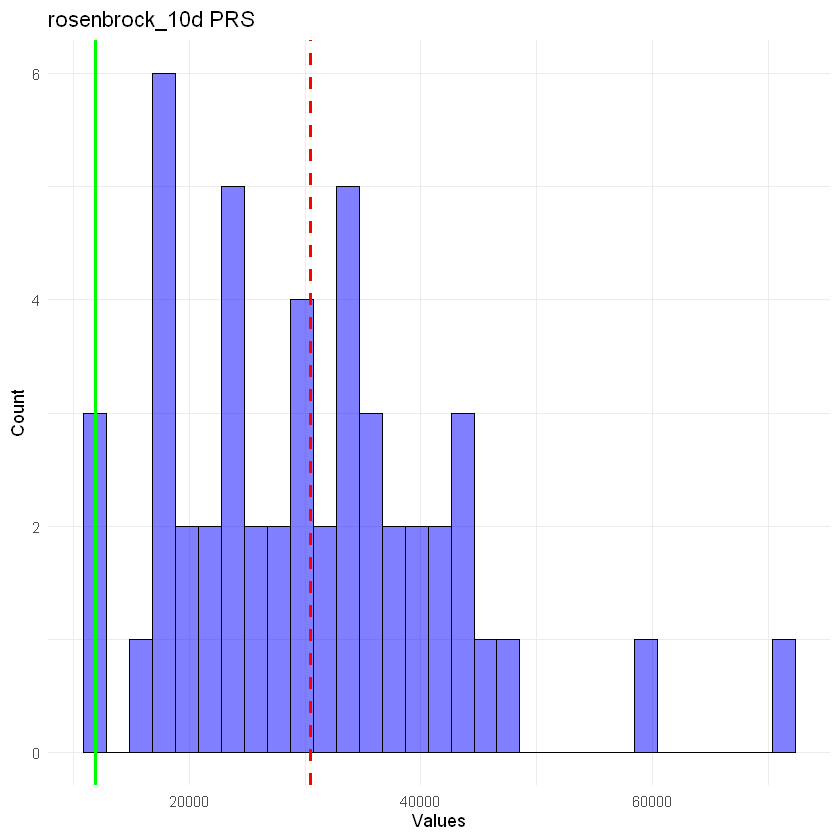

[1] "Generating plot for rosenbrock_20d PRS"


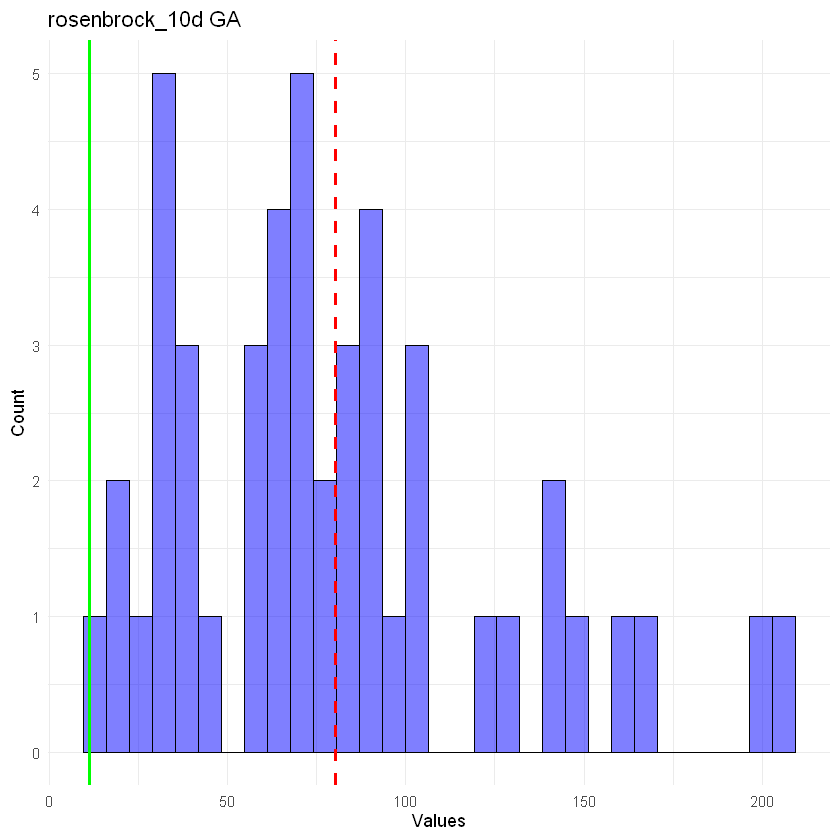

[1] "Generating plot for rosenbrock_20d GA"


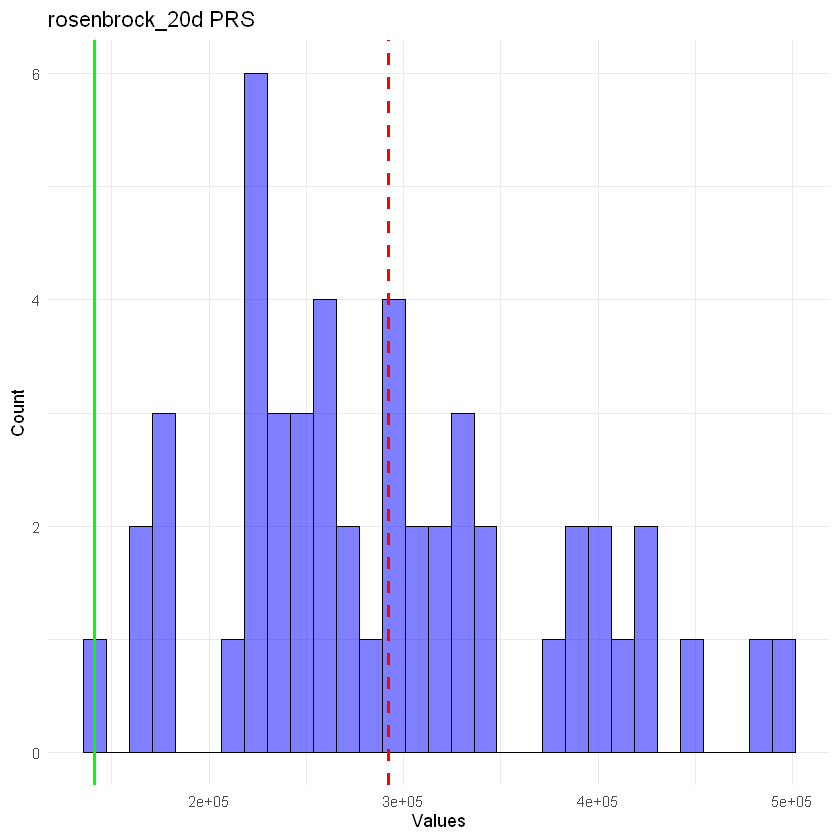

[1] "Generating plot for rastrigin_2d PRS"


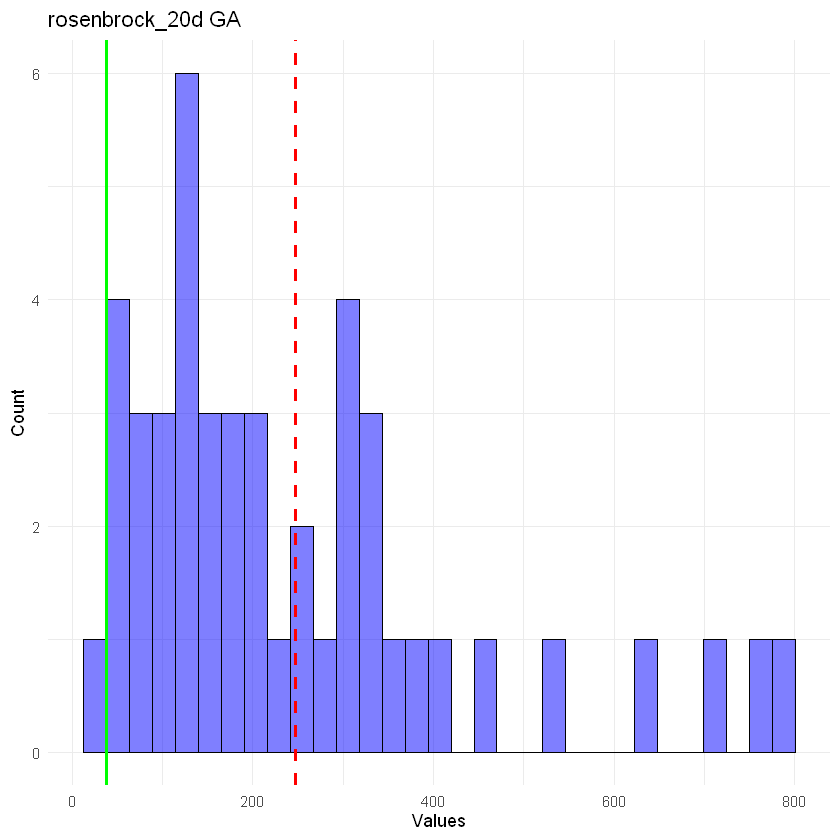

[1] "Generating plot for rastrigin_2d GA"


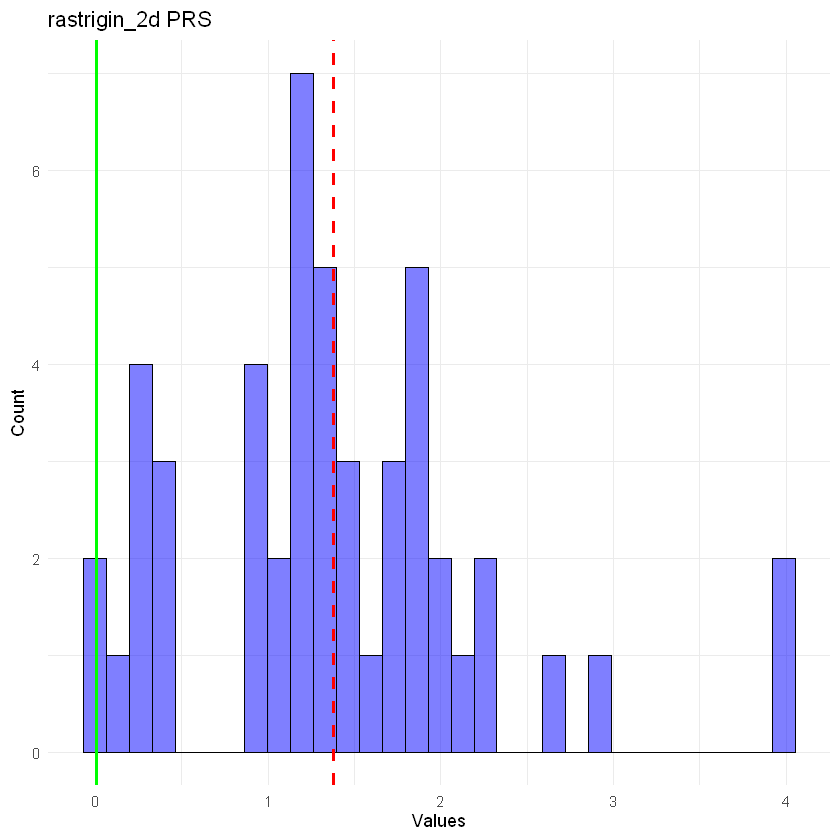

[1] "Generating plot for rastrigin_10d PRS"


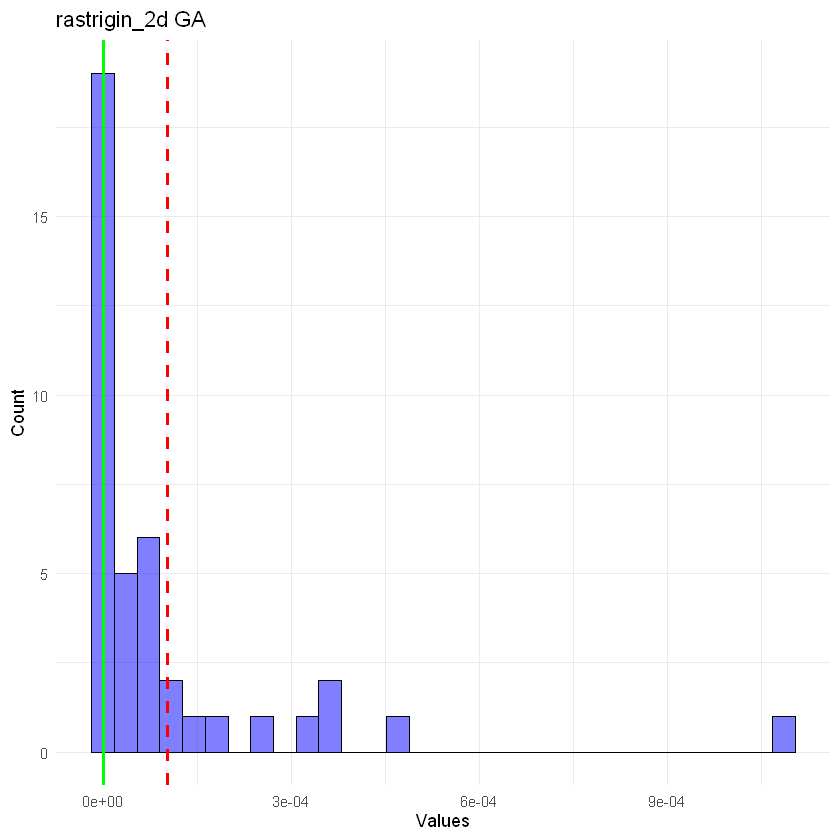

[1] "Generating plot for rastrigin_10d GA"


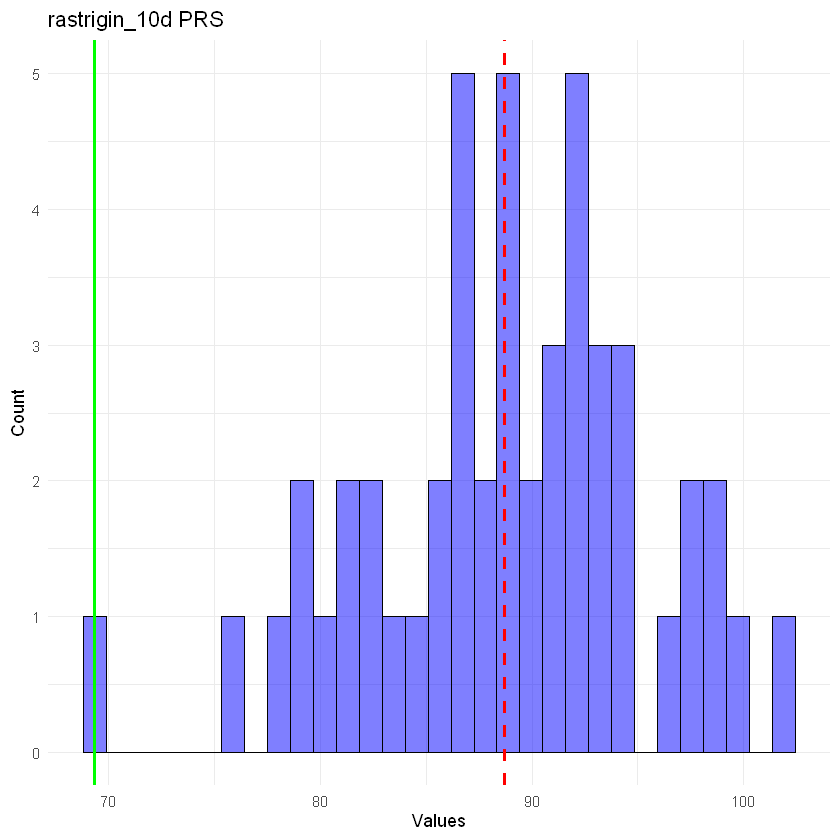

[1] "Generating plot for rastrigin_20d PRS"


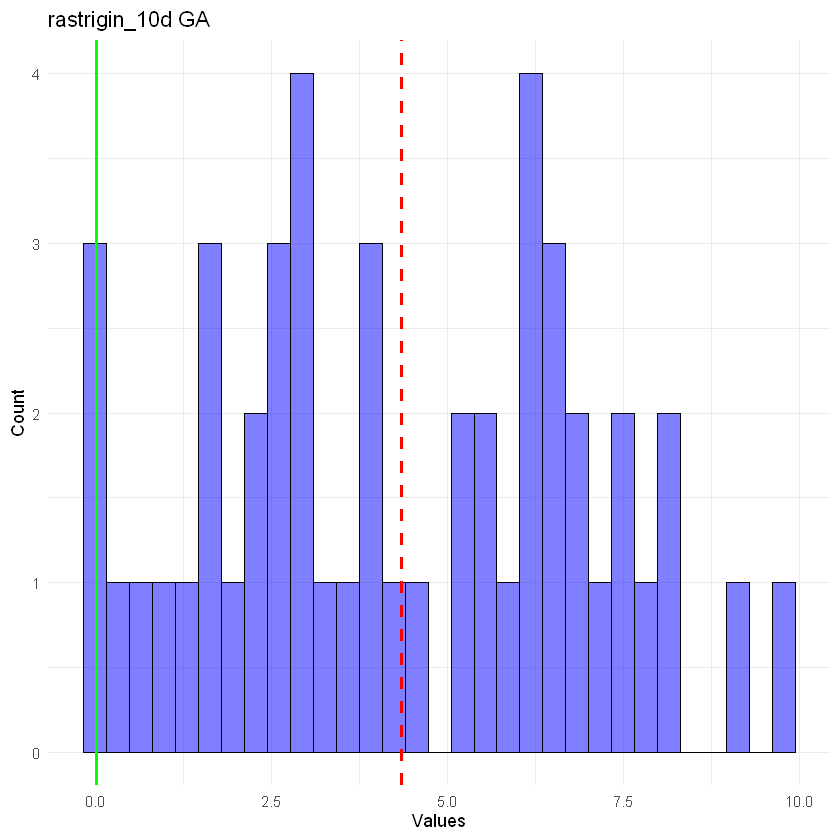

[1] "Generating plot for rastrigin_20d GA"


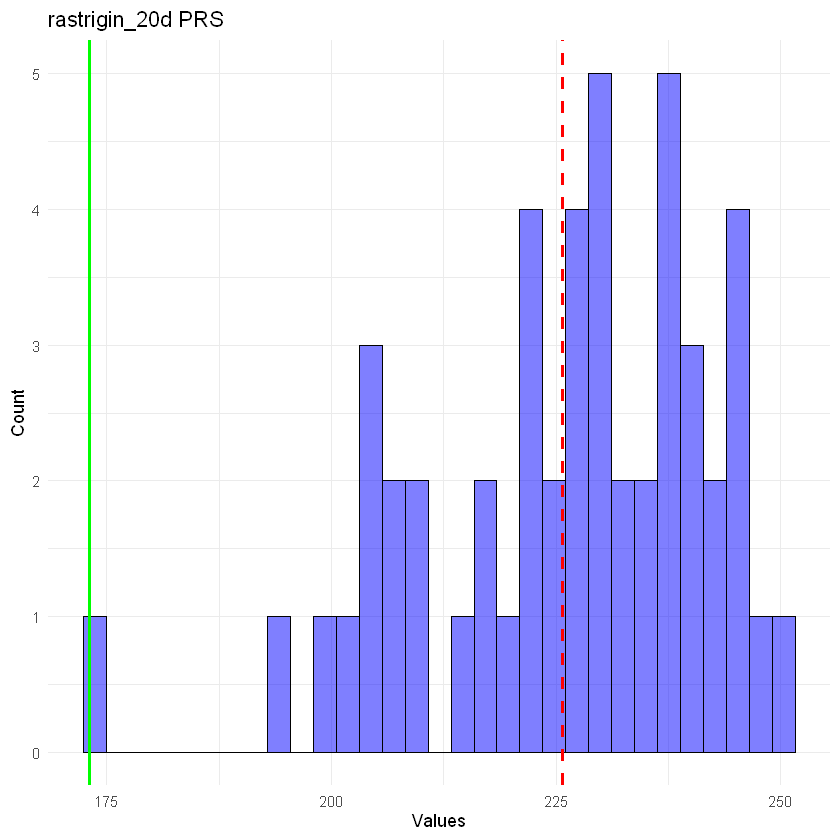

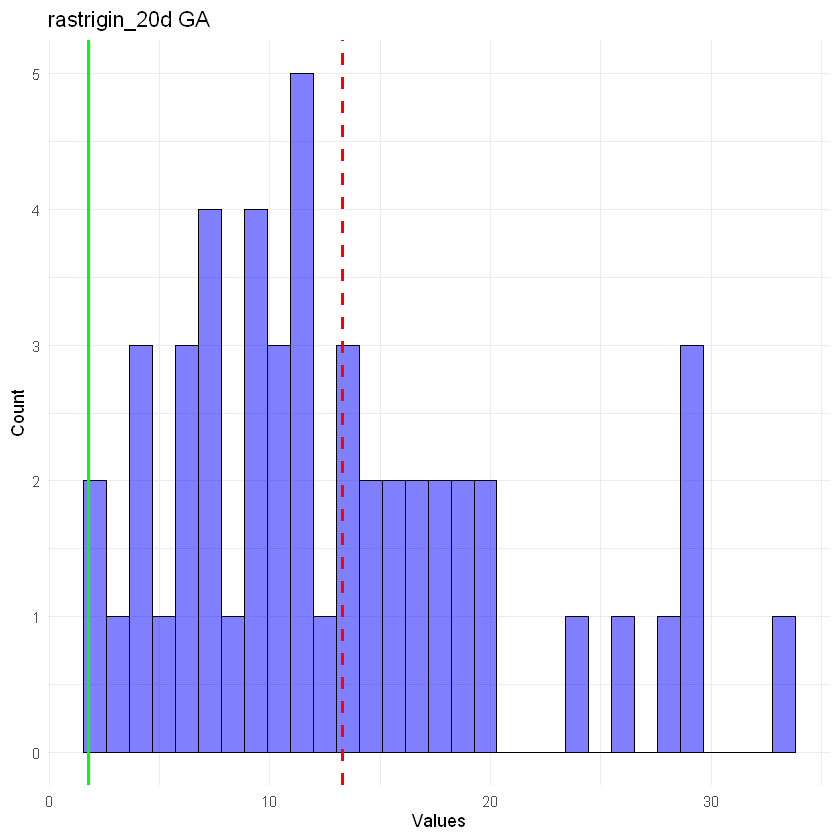

In [ ]:
generate_plot <- function(data, function_name, algorithm_name) {
  subset_data <- data %>%
    filter(Function == function_name, Algorithm == algorithm_name)
  
  subset_data <- subset_data %>%
    filter(!is.na(Value) & is.finite(Value))


  # mean_value <- mean(subset_data$Value, na.rm = TRUE)
  # mediana lepsza
  median_value <- median(subset_data$Value, na.rm = TRUE)
  iqr_value <- IQR(subset_data$Value, na.rm = TRUE)
  
  subset_data <- subset_data %>%
    filter(Value >= (median_value - 3 * iqr_value) & Value <= (median_value + 3 * iqr_value))
  
  bin_width <- diff(range(subset_data$Value)) / 30
  
  ggplot(subset_data, aes(x = Value)) +
    geom_histogram(binwidth = bin_width, fill = "blue", color = "black", alpha = 0.5) +
    geom_vline(aes(xintercept = min(Value, na.rm = TRUE)), color = "green", size = 1) +
    geom_vline(aes(xintercept = mean(Value, na.rm = TRUE)), color = "red", linetype = "dashed", size = 1) +
    labs(
      title = paste(function_name, algorithm_name),
      x = "Values",
      y = "Count"
    ) +
    theme_minimal()
}

for (function_name in c("rosenbrock_2d", "rosenbrock_10d", "rosenbrock_20d", "rastrigin_2d", "rastrigin_10d", "rastrigin_20d")) {
  for (algorithm_name in c("PRS", "GA")) {
    print(paste("Generating plot for", function_name, algorithm_name))
    plot <- generate_plot(results, function_name, algorithm_name)
    if (!is.null(plot)) print(plot)
  }
}


In [37]:
statistical_analysis <- function(results) {
  results %>%
    group_by(Function, Algorithm) %>%
    summarise(Mean = mean(Value), SD = sd(Value)) %>%
    ungroup()
}

t_tests <- lapply(names(experiments), function(fun) {
  ms_values <- results %>% filter(Function == fun & Algorithm == "PRS") %>% pull(Value)
  ga_values <- results %>% filter(Function == fun & Algorithm == "GA") %>% pull(Value)
  t.test(ms_values, ga_values)
})

t_tests

[[1]]

	Welch Two Sample t-test

data:  ms_values and ga_values
t = 7.6769, df = 50.794, p-value = 4.781e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4658633 0.7958434
sample estimates:
 mean of x  mean of y 
0.66194436 0.03109098 


[[2]]

	Welch Two Sample t-test

data:  ms_values and ga_values
t = 17.909, df = 49.006, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 26944.44 33755.64
sample estimates:
  mean of x   mean of y 
30448.02696    97.98833 


[[3]]

	Welch Two Sample t-test

data:  ms_values and ga_values
t = 23.842, df = 49.003, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 267045.2 316205.7
sample estimates:
  mean of x   mean of y 
291986.8879    361.4241 


[[4]]

	Welch Two Sample t-test

data:  ms_values and ga_values
t = 10.17, df = 54.439, p-value = 3.423e-14
alterna